In [1]:
import glob
import numpy as np
import h5py
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.metrics.pairwise import euclidean_distances


In [2]:
def make_ann(img):
    
    # Produces binary annotation mask from annotated image.
    # It was agreed to make annotations in green color.
    ann = np.zeros(shape = img[:, :, 0].shape)
    ann[(img[:, :, 0] == 76) & (img[:, :, 1] == 255) & (img[:, :, 2] == 0)] = 1.
    return ann

def make_msk(orig):
    
    # Produces binary mask of a glomerulus from original image.
    msk = np.sum(orig, axis = 2)
    msk[msk != 0] = 1.
    return msk

def make_hmap(msk, ann, c1 = -10, c2 = 7, t = True):
    
    # Produces localization heatmap based on distance to annotation.
    hmap = msk.copy()
    ptsm = np.column_stack([np.nonzero(msk)[1], np.nonzero(msk)[0]])
    ptsm2 = np.column_stack([np.nonzero(ann)[1], np.nonzero(ann)[0]])
    
    # For each point in mask calculate distance to nearest point in an annotation.
    for pt in ptsm:
        d = np.min(euclidean_distances(pt.reshape(-1, 2), ptsm2))
        hmap[pt[1], pt[0]] = d
        
    hmap = hmap / hmap.max()
    
    # Inversion.
    hmap = 1. - hmap
    hmap[msk == 0] = 0
    
    if t:
        
        # Make linear to exponential transformation.
        hmap = 1/(1 + np.e**(c1 * hmap + c2))
        hmap[msk == 0] = 0
        return hmap
        
    else:
        return hmap


In [3]:
nams = ['Crescentic', 'Endocapillary', 'FSGS','Mesangioproliferative', ]

In [4]:
nams

['Crescentic', 'Endocapillary', 'FSGS', 'Mesangioproliferative']

In [5]:
int_labels = np.array([i for i,_ in enumerate(nams)])

In [6]:
int_labels

array([0, 1, 2, 3])

## Demo heatmap generation

In [7]:
annotated_imgs = []
original_imgs = []
anns = []
msks = []
hmaps = []

pths_a = sorted(glob.glob('./demo_images/sample_annotated_image_*.png'))
pths_o = sorted(glob.glob('./demo_images/original_*.png'))

for pth_o, pth_a in zip(pths_o, pths_a):
    annotated_imgs.append(imread(pth_a)[:, :, :3])
    original_imgs.append(imread(pth_o)[:, :, :3])
    anns.append(make_ann(annotated_imgs[-1]))
    msks.append(make_msk(original_imgs[-1]))
    
    # Make heatmaps with default parameters.
    hmaps.append(make_hmap(msks[-1], anns[-1]))


In [8]:
annotated_imgs = np.array(annotated_imgs)
original_imgs = np.array(original_imgs)
anns = np.array(anns)
msks = np.array(msks)
hmaps = np.array(hmaps)

In [9]:
%%script echo 'Remove this line to execute the code in this cell.'
# Save dataset file.
with h5py.File('./dataset.h5', 'w') as f:
    
    # Larger datasets can be appended to .h5 file in chunks.
    f.create_dataset('labels', data = int_labels)
    f.create_dataset('images', data = original_imgs / 255) # Stores images as float type.
    f.create_dataset('gt_heatmaps', data = hmaps)
    
# Check if data is ok.
with h5py.File('./dataset.h5', 'r') as f:
    for key in f.keys():
        print(key, f[key].shape, f[key].dtype)

Remove this line to execute the code in this cell.


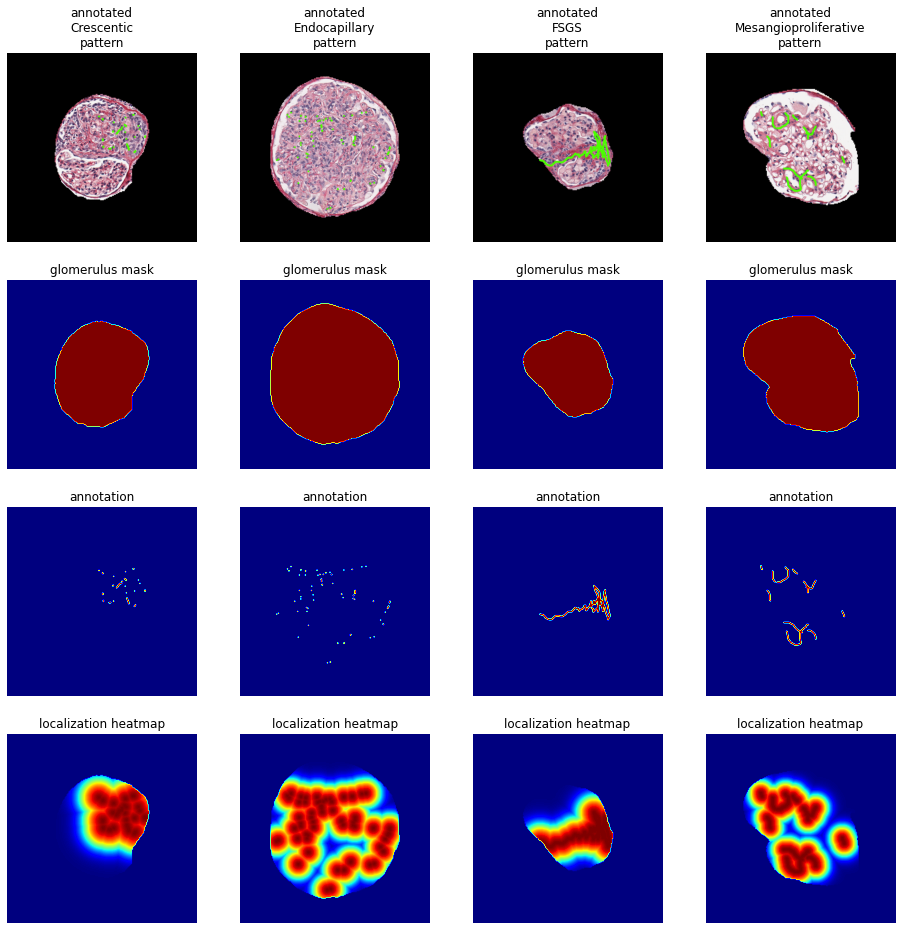

In [16]:
sf = 4
plt.figure(figsize = (annotated_imgs.shape[0] * sf, 4 * sf))
n = 1
for i, (ims, nam) in enumerate(zip([annotated_imgs,msks,anns,hmaps],
                                   ['annotated', 'glomerulus mask', 'annotation', 'localization heatmap'])):
    
    for j in range(annotated_imgs.shape[0]):
        plt.subplot(4, annotated_imgs.shape[0], n)
        if nam == 'annotated':
            plt.title(f'{nam}\n{nams[j]}\npattern')
        else:
            plt.title(nam)
        
        plt.imshow(ims[j], cmap = 'jet')
        
        plt.axis('off')
        n += 1

## Coeficients for heatmap transformations

In [11]:
# Generate heatmap without exponential transformation.
n = 0
hmap = make_hmap(msks[n], anns[n], t = False)

In [12]:
# Apply tranformations.
hmaps_t = []
coefs = []
for c1 in np.arange(-6, -15, -2):
    for c2 in np.arange(11, 2, -2):
        hmap_t = hmap.copy()
        hmap_t = 1 / (1 + np.e**(c1 * hmap_t + c2))
        hmap_t[msks[n] == 0] = 0.
        hmaps_t.append(hmap_t)
        coefs.append([c1, c2])


Text(0.5, 1.0, 'non-transformed heatmap')

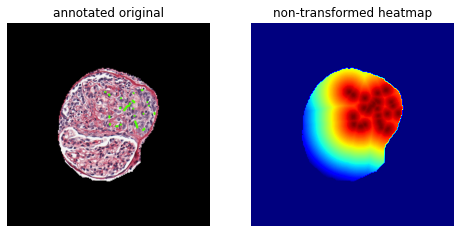

In [13]:
# Visualize non-transformed heatmap.
plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.imshow(annotated_imgs[n])
plt.axis('off')
plt.title('annotated original')
plt.subplot(1, 2, 2)
plt.imshow(hmap, cmap = 'jet')
plt.axis('off')
plt.title('non-transformed heatmap')

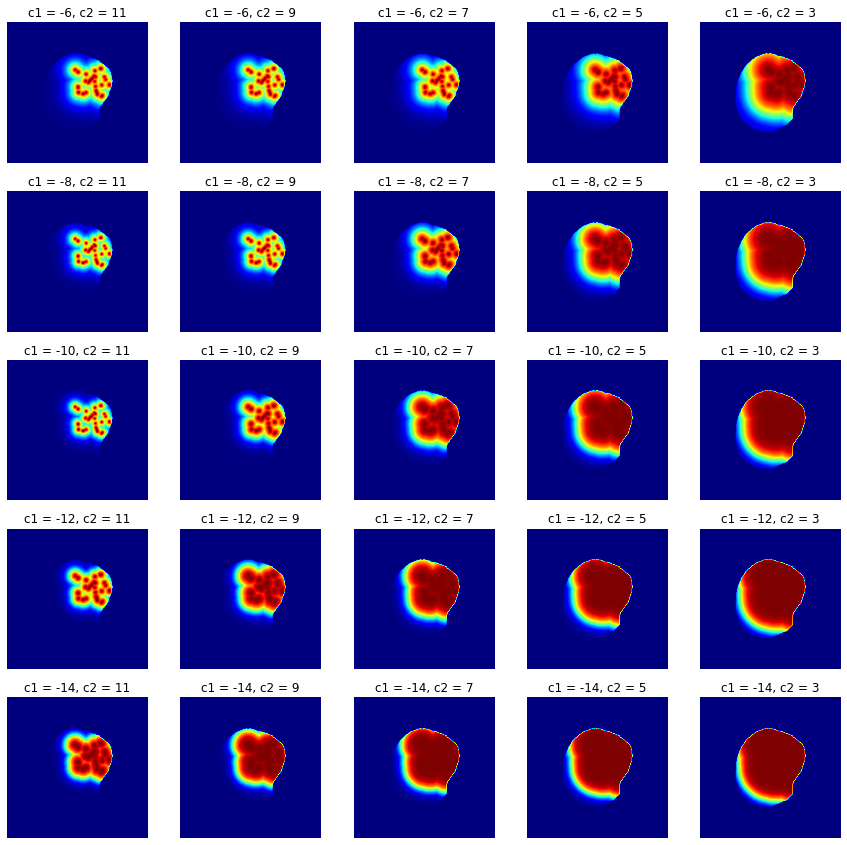

In [14]:
# Visualize transformed heatmaps.
plt.figure(figsize = (15, 15))
for i in range(len(hmaps_t)):
    c1, c2 = coefs[i]
    plt.subplot(5, 5, i + 1)
    plt.imshow(hmaps_t[i], cmap = 'jet', alpha = 1.)
    plt.axis('off')
    plt.title('c1 = ' + str(c1) + ', c2 = ' + str(c2))